In [17]:
from hossam import load_data
from pandas import DataFrame, get_dummies
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

import statsmodels.api as sm

from sklearn.metrics import confusion_matrix,roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [10]:
my_dpi = 200                                    # 이미지 선명도(100~300)
font_path = "./NotoSansKR-Regular.ttf"          # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)               # 폰트의 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname=font_path)  # 폰트의 속성을 읽어옴
font_name = font_prop.get_name()                # 읽어온 속성에서 폰트의 이름만 추출     
plt.rcParams['font.family'] = font_name         # 그래프에 한글 폰트 적용
plt.rcParams['font.size'] = 10                  # 기본 폰트크기
plt.rcParams['axes.unicode_minus'] = False      # 그래프에 마이너스 깨짐 방지(한글환경에서 필수)

In [11]:
origin = load_data('pima_indians_diabetes')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 타입확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/kaggle/pima_indians_diabetes.xlsx
[desc] 이 데이터 세트는 원래 미국 국립 당뇨병·소화기·신장질환 연구소(National Institute of Diabetes and Digestive and Kidney Diseases)에서 제공한 것입니다. 이 데이터 세트의 목적은 데이터 세트에 포함된 특정 진단 측정값을 기반으로 환자의 당뇨병 여부를 진단적으로 예측하는 것입니다. 더 큰 데이터베이스에서 이러한 사례를 선택하는 데에는 몇 가지 제약 조건이 적용되었습니다. 특히, 여기에 포함된 모든 환자는 21세 이상의 피마 인디언 혈통을 가진 여성입니다. (출처: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

field                     type    description
------------------------  ------  --------------------------------
Pregnancies               연속형  임신횟수
Glucose                   연속형  포도당 부하 검사 수치
BloodPressure             연속형  혈압
SkinThickness             연속형  팔 삼두근 뒤쪽의 피하지방 측정값
Insulin                   연속형  혈청 인슐린
BMI                       연속형  체질량 지수
DiabetesPedigreeFunction  연속형  당뇨 내력 가중치 값
Age                       연속형  나이
Outcome                   명목형  당뇨여부(0 또는 1)


===== 데이터 크기 확인 =====
데이터셋 크기: (768, 9)
열 개수: 9
행 개수: 768

===== 타입확인 =====
<class 'pand

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [12]:
yname = 'Outcome'  #종속변수 이름

x = origin.drop(yname, axis=1)     #독립변수만 추출(DataFrame 형태)
y = origin[yname]                  #종속변수만 추출(Series형태)

x_input= sm.add_constant(x)        #독립변수에 상수항 추가

fit = sm.Logit(y, x_input).fit()
tbl1 = fit.summary()
print(tbl1)

Optimization terminated successfully.
         Current function value: 0.470993
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      759
Method:                           MLE   Df Model:                            8
Date:                   화, 16 12 2025   Pseudo R-squ.:                  0.2718
Time:                        12:38:38   Log-Likelihood:                -361.72
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 9.652e-54
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -8.4047      0.717    -11.728      0.000      -9.809

In [13]:
def logit_report(fit, data, threshold=0.5):
    
    
    #성능평가지표
    yname = fit.model.endog_names
    y_true = data[yname]
    y_pred = fit.predict(fit.model.exog)
    y_pred_fix = (y_pred>=threshold).astype(int)
    
    #혼동행렬
    cm=confusion_matrix(y_true, y_pred_fix)
    tn, fp, fn, tp=cm.ravel()

    acc = accuracy_score(y_true, y_pred_fix)
    pre = precision_score(y_true, y_pred_fix)
    tpr = recall_score(y_true, y_pred_fix)
    fpr = fp/(fp+tn)
    tnr = 1-fpr
    f1 = f1_score(y_true, y_pred_fix)
    ras = roc_auc_score(y_true, y_pred)

    cdf = DataFrame({
        '설명력:[fit.prsquared]'
        '정확도':[acc],
        '정밀도': [pre], 
        '재현율':[tpr],
        '위양성율':[fpr],
        '특이성':[tnr],
        'RAS':[ras],
        'F1':[f1]

    })
    #회귀계수 표 구성(or중심)
    tbl = fit.summary()

    #종속변수명
    yname = fit.model.endog_names
    #독립변수 이름(상수항 제외)
    xnames= [n for n in fit.model.exog_names if n !="const"]

    #독립변수
    x=data[xnames]

    variables = []

    #vif 계산
    vif_dict = {
        col: variance_inflation_factor(x.values, i)
        for i,col in enumerate(x.columns)
    }

    for v in tbl.tables[1].data:
        name = v[0].strip()
        if name not in xnames:
            continue
        beta = float(v[1])
        se = float(v[2])
        z = float(v[3])
        p = float(v[4])

        or_val = np.exp(beta)
        ci_low = np.exp(beta - 1.96 *se)
        ci_high = np.exp(beta +1.96 *se)

        stars = (
            "***" if p<0.001 else
            "**" if p<0.01 else
            "*" if p<0.05 else
            "")
        
        variables.append({
            "종속변수": yname,
            "독립변수": name,
            "B":beta,
            "표준오차":se,
            "z":f"{z:.3f}{stars}",
            "p-value":p,
            "OR":or_val, 
            "CI_lower":ci_low,
            "CI_upper":ci_high,
            "VIF":vif_dict.get(name, np.nan)

        })

    rdf = DataFrame(variables)

    #모델 적합도+예측 성능 지표
    y_true = data[yname]
    y_prob = fit.predict(fit.model.exog)
    y_pred = (y_prob>=threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_fix).ravel()

    acc = accuracy_score(y_true, y_pred_fix)
    pre =precision_score(y_true, y_pred_fix)
    rec = recall_score(y_true, y_pred_fix)
    f1 = f1_score(y_true, y_pred_fix)
    auc = roc_auc_score(y_true, y_prob)

    result_report=(
        f"Pseudo R^2(McFadden) = {fit.prsquared:.3f},"
        f"LLR X^2({int(fit.df_model)}) = {fit.llr:.3f},"
        f"p-value = {fit.llr_pvalue:.4f},"
        f"Auccuracy = {auc:.3f}"
    )
    #모형 보고 문장

    tpl = (
        "%s에 대하여 %s로 예측하는 로지스틱 회귀분석을 실시한 결과,"
        "모형은 통계적으로 %s(X^2(%s)=%.3f, p%s 0.05)하였다."
    )

    model_report = tpl %(
        yname,
        ",".join(xnames),
        "유의" if fit.llr_pvalue <=0.05 else "유의하지 않음",
        int(fit.df_model),
        fit.llr,
        "<="if fit.llr_pvalue<=0.05 else">"
    )
    #변수별 보고 문장

    variable_reports=[]
    s=(
        "%s의 오즈비는 %.3f(p%s 0.05)로,"
        "%s 발생 odds에 %s영향을 미치는 것으로 나타났다."
    )

    for _,row in rdf.iterrows():
        variable_reports.append(
            s%(row["독립변수"],row["OR"],"<="if row["p-value"]<0.05 else ">",row["종속변수"],"유의미한"if row["p-value"]<0.05 else"유의하지 않은"
            )
        )
    return cdf, rdf, result_report, model_report, variable_reports

 Logit summary(tbl)와 데이터 프레임(data)을 받아
    회귀계수 표(rdf),
    모델 적합도 요약(result_report),
    모형보고 문장(model_report),
    변수별 보고 리스트(variable_reports)를 반환한다.

In [14]:
cdf, rdf, r,m,v =logit_report(fit, origin)
display(cdf)
display(rdf)
display(r)
display(m)
display(v)

,설명력:[fit.prsquared]정확도,정밀도,재현율,위양성율,특이성,RAS,F1
0,0.782552,0.739336,0.58209,0.11,0.89,0.839425,0.651357


,종속변수,독립변수,B,표준오차,z,p-value,OR,CI_lower,CI_upper,VIF
0,Outcome,Pregnancies,0.1232,0.032,3.840***,0.000,1.131111,1.062346,1.204326,3.275748
1,Outcome,Glucose,0.0352,0.004,9.481***,0.000,1.035827,1.027738,1.043980,16.725078
2,Outcome,BloodPressure,-0.0133,0.005,-2.540*,0.011,0.986788,0.977165,0.996506,14.619512
3,Outcome,SkinThickness,0.0006,0.007,0.090,0.929,1.000600,0.986966,1.014423,4.008696
4,Outcome,Insulin,-0.0012,0.001,-1.322,0.186,0.998801,0.996845,1.000760,2.063689
5,Outcome,BMI,0.0897,0.015,5.945***,0.000,1.093846,1.062155,1.126483,18.408884
6,Outcome,DiabetesPedigreeFunction,0.9452,0.299,3.160**,0.002,2.573328,1.432126,4.623907,3.195626
7,Outcome,Age,0.0149,0.009,1.593,0.111,1.015012,0.997264,1.033075,13.492985


'Pseudo R^2(McFadden) = 0.272,LLR X^2(8) = 270.039,p-value = 0.0000,Auccuracy = 0.839'

'Outcome에 대하여 Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age로 예측하는 로지스틱 회귀분석을 실시한 결과,모형은 통계적으로 유의(X^2(8)=270.039, p<= 0.05)하였다.'

['Pregnancies의 오즈비는 1.131(p<= 0.05)로,Outcome 발생 odds에 유의미한영향을 미치는 것으로 나타났다.',
 'Glucose의 오즈비는 1.036(p<= 0.05)로,Outcome 발생 odds에 유의미한영향을 미치는 것으로 나타났다.',
 'BloodPressure의 오즈비는 0.987(p<= 0.05)로,Outcome 발생 odds에 유의미한영향을 미치는 것으로 나타났다.',
 'SkinThickness의 오즈비는 1.001(p> 0.05)로,Outcome 발생 odds에 유의하지 않은영향을 미치는 것으로 나타났다.',
 'Insulin의 오즈비는 0.999(p> 0.05)로,Outcome 발생 odds에 유의하지 않은영향을 미치는 것으로 나타났다.',
 'BMI의 오즈비는 1.094(p<= 0.05)로,Outcome 발생 odds에 유의미한영향을 미치는 것으로 나타났다.',
 'DiabetesPedigreeFunction의 오즈비는 2.573(p<= 0.05)로,Outcome 발생 odds에 유의미한영향을 미치는 것으로 나타났다.',
 'Age의 오즈비는 1.015(p> 0.05)로,Outcome 발생 odds에 유의하지 않은영향을 미치는 것으로 나타났다.']

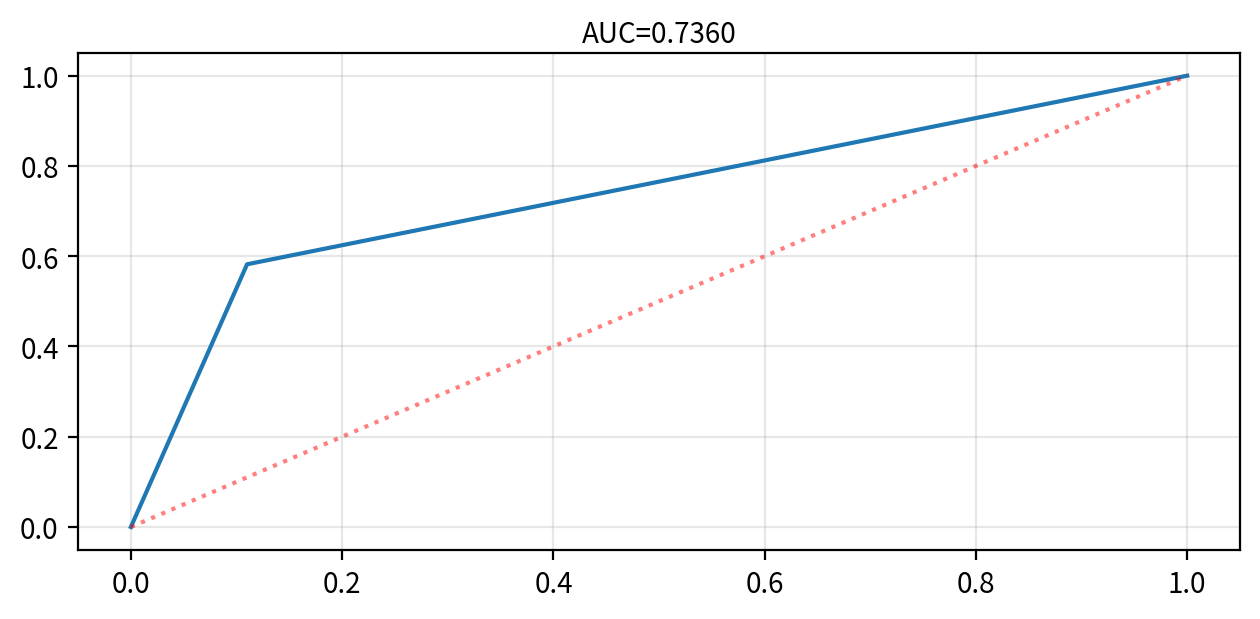

In [18]:
y_true = origin[yname]
y_prob = fit.predict(fit.model.exog)
y_pred = (y_prob>=0.5).astype(int)

ras = roc_auc_score(y_true, y_pred)

roc_fpr, roc_tpr, thresholds = roc_curve(y_true, y_pred)

width_px = 1280
height_px = 640
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

sb.lineplot( x=roc_fpr, y=roc_tpr)
sb.lineplot( x=[0,1], y=[0,1],color = 'red', linestyle=":", alpha=0.5)

ax.set_title(f'AUC={ras:.4f}', fontsize=10, pad=4)
ax.grid(True, alpha=0.3)



plt.tight_layout()
plt.show()
plt.close()

In [19]:
# 독립변수 로그 변환

In [20]:
df =origin.copy()

#종속/독립 변수
yname = "Outcome"
y = df[yname]
x = df.drop(columns=[yname])
#로그변환 대상 변수(연속형만 명시)
log_vars =x.columns
#로그변환 (0값 대응)
for v in log_vars:
    df[f"log_{v}"] = np.log1p(df[v])
    #원변수 제거
df.drop(columns=log_vars, inplace=True)
#로지스틱 회귀
X_log = df.drop(columns = [yname])
X_input = sm.add_constant(X_log)

fit = sm.Logit(y,X_input).fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.516943
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      759
Method:                           MLE   Df Model:                            8
Date:                   화, 16 12 2025   Pseudo R-squ.:                  0.2008
Time:                        12:59:20   Log-Likelihood:                -397.01
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 8.305e-39
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          -25.6571      2.490    -10.303      0.000

1.날것의 데이터로 로지스틱회귀를 돌려본다.
2.로그변환해서 로지스틱 회귀를 돌려본다.
3.둘중에 어떤것이 더 적합한지 판별한다.
4.더 적합한 모델에 vif내용을 수정한다.

In [21]:
cdf, rdf, r, m, v=logit_report(fit, df)
display(cdf)
display(rdf)
display(r)
display(m)
display(v)

,설명력:[fit.prsquared]정확도,정밀도,재현율,위양성율,특이성,RAS,F1
0,0.769531,0.719807,0.55597,0.116,0.884,0.836187,0.627368


,종속변수,독립변수,B,표준오차,z,p-value,OR,CI_lower,CI_upper,VIF
0,Outcome,log_Pregnancies,0.3125,0.136,2.305*,0.021,1.366838,1.047012,1.784360,5.186143
1,Outcome,log_Glucose,2.9775,0.404,7.366***,0.000,19.638659,8.896518,43.351443,88.500549
2,Outcome,log_BloodPressure,-0.2716,0.106,-2.562*,0.010,0.762159,0.619180,0.938155,25.483998
3,Outcome,log_SkinThickness,0.0359,0.077,0.469,0.639,1.036552,0.891348,1.205410,6.105680
4,Outcome,log_Insulin,-0.0416,0.047,-0.879,0.379,0.959253,0.874835,1.051818,3.618666
5,Outcome,log_BMI,1.9870,0.467,4.253***,0.000,7.293620,2.920281,18.216358,59.762583
6,Outcome,log_DiabetesPedigreeFunction,1.6688,0.452,3.689***,0.000,5.305797,2.187764,12.867696,4.668408
7,Outcome,log_Age,1.1022,0.342,3.220**,0.001,3.010782,1.540150,5.885667,118.849755


'Pseudo R^2(McFadden) = 0.201,LLR X^2(8) = 199.460,p-value = 0.0000,Auccuracy = 0.836'

'Outcome에 대하여 log_Pregnancies,log_Glucose,log_BloodPressure,log_SkinThickness,log_Insulin,log_BMI,log_DiabetesPedigreeFunction,log_Age로 예측하는 로지스틱 회귀분석을 실시한 결과,모형은 통계적으로 유의(X^2(8)=199.460, p<= 0.05)하였다.'

['log_Pregnancies의 오즈비는 1.367(p<= 0.05)로,Outcome 발생 odds에 유의미한영향을 미치는 것으로 나타났다.',
 'log_Glucose의 오즈비는 19.639(p<= 0.05)로,Outcome 발생 odds에 유의미한영향을 미치는 것으로 나타났다.',
 'log_BloodPressure의 오즈비는 0.762(p<= 0.05)로,Outcome 발생 odds에 유의미한영향을 미치는 것으로 나타났다.',
 'log_SkinThickness의 오즈비는 1.037(p> 0.05)로,Outcome 발생 odds에 유의하지 않은영향을 미치는 것으로 나타났다.',
 'log_Insulin의 오즈비는 0.959(p> 0.05)로,Outcome 발생 odds에 유의하지 않은영향을 미치는 것으로 나타났다.',
 'log_BMI의 오즈비는 7.294(p<= 0.05)로,Outcome 발생 odds에 유의미한영향을 미치는 것으로 나타났다.',
 'log_DiabetesPedigreeFunction의 오즈비는 5.306(p<= 0.05)로,Outcome 발생 odds에 유의미한영향을 미치는 것으로 나타났다.',
 'log_Age의 오즈비는 3.011(p<= 0.05)로,Outcome 발생 odds에 유의미한영향을 미치는 것으로 나타났다.']

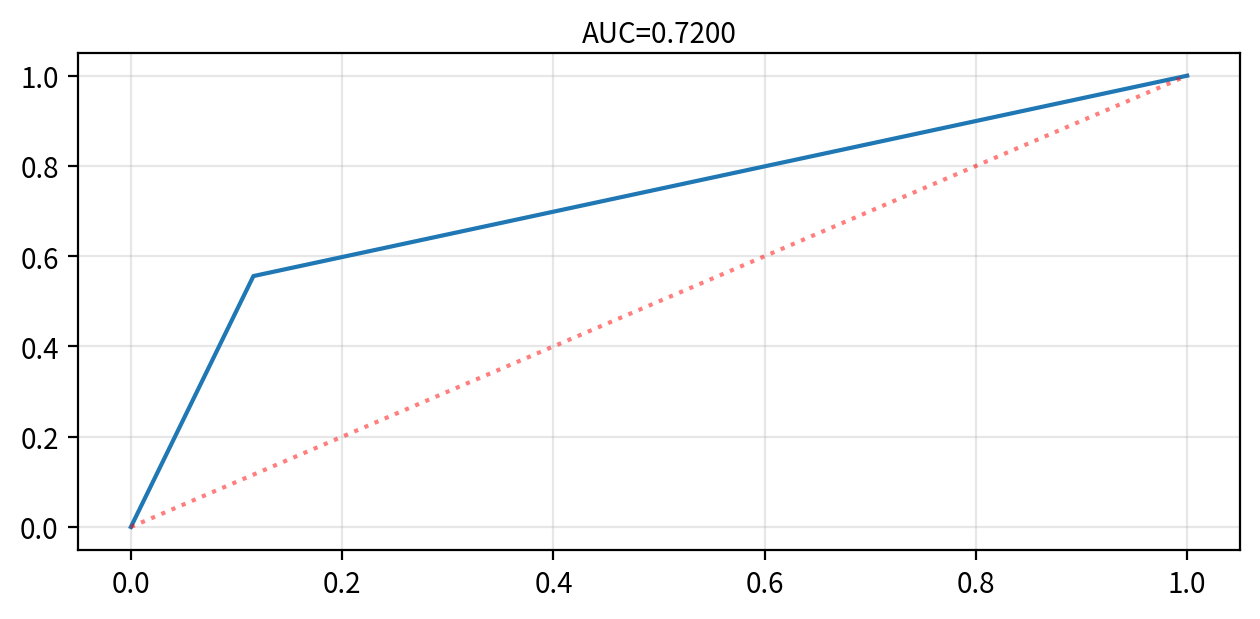

In [22]:
y_true = df[yname]
y_prob = fit.predict(fit.model.exog)
y_pred = (y_prob>=0.5).astype(int)

ras = roc_auc_score(y_true, y_pred)

roc_fpr, roc_tpr, thresholds = roc_curve(y_true, y_pred)

width_px = 1280
height_px = 640
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

sb.lineplot( x=roc_fpr, y=roc_tpr)
sb.lineplot( x=[0,1], y=[0,1],color = 'red', linestyle=":", alpha=0.5)

ax.set_title(f'AUC={ras:.4f}', fontsize=10, pad=4)
ax.grid(True, alpha=0.3)



plt.tight_layout()
plt.show()
plt.close()